# Predict Instruction

Build a model that predicts an accurate delivery time, from picking up a package to arriving at the final destination. An accurate arrival time prediction will help all businesses to improve their logistics and communicate an accurate time to their customers.


## Import packages

In [0]:
%%capture
!pip install catboost

import pandas as pd
import numpy as np
from google.colab import drive
pd.set_option('display.max_columns', 60)

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# For graphs
import seaborn as sns
sns.set(font_scale=1)

from IPython.core.pylabtools import figsize

# For the Q-Q plots
import scipy.stats as stats

# Split and standarize the dataset
from sklearn.preprocessing import StandardScaler

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn import metrics

# To evaluate the model
from sklearn.metrics import mean_squared_error

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



from google.colab import files

# Import Data

In [0]:
train_df = pd.read_csv('https://raw.githubusercontent.com/Maddy-Muir/team_7_regression/master/Data/Train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/Maddy-Muir/team_7_regression/master/Data/Test.csv')
riders_df = pd.read_csv('https://raw.githubusercontent.com/Maddy-Muir/team_7_regression/master/Data/Riders.csv')
sample_df = pd.read_csv('https://raw.githubusercontent.com/Maddy-Muir/team_7_regression/master/Data/SampleSubmission.csv')
variable_def = pd.read_csv('https://raw.githubusercontent.com/Maddy-Muir/team_7_regression/master/Data/VariableDefinitions.csv')

Display top of tables to get familiar with data


In [126]:
riders_df.head()

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156


In [127]:
train_df.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [128]:
test_df.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [129]:
sample_df.head()

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,567.0
1,Order_No_12736,4903.0
2,Order_No_768,5649.0
3,Order_No_15332,NaN
4,Order_No_21373,NaN


# See Description of Data Tables
Information gathered here includes amount of rows and columns as well as data types and null values

In [130]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [131]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              7068 non-null   object 
 1   User Id                               7068 non-null   object 
 2   Vehicle Type                          7068 non-null   object 
 3   Platform Type                         7068 non-null   int64  
 4   Personal or Business                  7068 non-null   object 
 5   Placement - Day of Month              7068 non-null   int64  
 6   Placement - Weekday (Mo = 1)          7068 non-null   int64  
 7   Placement - Time                      7068 non-null   object 
 8   Confirmation - Day of Month           7068 non-null   int64  
 9   Confirmation - Weekday (Mo = 1)       7068 non-null   int64  
 10  Confirmation - Time                   7068 non-null   object 
 11  Arrival at Pickup

#Definitions of the columns

In [132]:
variable_def

,Order No,Unique number identifying the order
0,User Id,Unique number identifying the customer on a pl...
1,Vehicle Type,"For this competition limited to bikes, however..."
2,Platform Type,"Platform used to place the order, there are 4 ..."
3,Personal or Business,Customer type
4,Placement - Day of Month,Placement - Day of Month i.e 1-31
5,Placement - Weekday (Mo = 1),Placement - Weekday (Monday = 1)
6,Placement - Time,Placement - Time - Time of day the order was p...
7,Confirmation - Day of Month,Confirmation - Day of Month i.e 1-31
8,Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Monday = 1)
9,Confirmation - Time,Confirmation - Time - Time of day the order wa...


# Joining DataFrames

Join riders_df to test_df and train_df on the 'Rider Id'

In [0]:
training_df = pd.merge(train_df, riders_df, how = 'inner', on = 'Rider Id')

In [0]:
testing_df = pd.merge(test_df, riders_df, how = 'inner', on = 'Rider Id')

#Checking for duplicates
Confirm there is no duplicated rows in the data

In [135]:
training_df[training_df.duplicated(keep=False)]

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings


# Cleaning of Data

Check percentage of null values in each column in order to eliminate columns with too many null values.

In [136]:
columns = training_df.columns
percent_missing_values = training_df.isnull().sum()/len(training_df.index)*100
missing_value_df = pd.DataFrame({'column_name': columns,'percent_missing': percent_missing_values})
missing_value_df

,column_name,percent_missing
Order No,Order No,0.000000
User Id,User Id,0.000000
Vehicle Type,Vehicle Type,0.000000
Platform Type,Platform Type,0.000000
Personal or Business,Personal or Business,0.000000
Placement - Day of Month,Placement - Day of Month,0.000000
Placement - Weekday (Mo = 1),Placement - Weekday (Mo = 1),0.000000
Placement - Time,Placement - Time,0.000000
Confirmation - Day of Month,Confirmation - Day of Month,0.000000
Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Mo = 1),0.000000


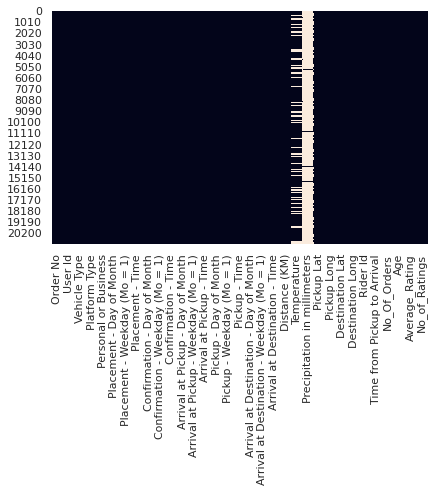

In [137]:
sns.heatmap(training_df.isnull(), cbar=False)

## Drop columns which are not relevant

Precipitation in millimeters - 97.4% Null values

Temerature at time of order placement - 20.6% Null values and not relevant

Vehicle type - String for all rows are identical = 'Bike'

In [0]:
training_df = training_df.drop(['Vehicle Type', 'Temperature', 'Precipitation in millimeters' ], axis = 1)

In [0]:
testing_df = testing_df.drop(['Vehicle Type', 'Temperature', 'Precipitation in millimeters' ], axis = 1)

In [140]:
training_df.head()

,Order No,User Id,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_27440,User_Id_2642,3,Personal,18,5,3:41:17 PM,18,5,3:41:30 PM,18,5,4:07:16 PM,18,5,4:13:37 PM,18,5,5:01:43 PM,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549
2,Order_No_14170,User_Id_3339,3,Business,31,5,12:51:41 PM,31,5,1:12:49 PM,31,5,1:20:02 PM,31,5,1:33:08 PM,31,5,2:16:43 PM,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549
3,Order_No_21727,User_Id_3523,3,Personal,2,2,7:12:10 AM,2,2,7:12:29 AM,2,2,7:35:24 AM,2,2,7:38:46 AM,2,2,8:28:32 AM,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549
4,Order_No_8301,User_Id_87,2,Personal,22,2,10:40:58 AM,22,2,10:42:24 AM,22,2,10:56:00 AM,22,2,10:59:40 AM,22,2,11:26:22 AM,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549


In [141]:
testing_df.head()

,Order No,User Id,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_19248,User_Id_3355,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171
1,Order_No_2699,User_Id_592,1,Personal,26,2,2:43:21 PM,26,2,2:47:16 PM,26,2,3:09:26 PM,26,2,3:17:48 PM,19,-1.312745,36.875715,-1.288435,36.760677,Rider_Id_192,439,1511,13.3,171
2,Order_No_21486,User_Id_478,3,Business,29,5,11:55:05 AM,29,5,11:58:12 AM,29,5,12:25:49 PM,29,5,12:28:54 PM,9,-1.255189,36.782203,-1.293393,36.790237,Rider_Id_192,439,1511,13.3,171
3,Order_No_19336,User_Id_2801,3,Business,2,1,9:23:21 AM,2,1,9:23:44 AM,2,1,9:44:50 AM,2,1,10:05:31 AM,15,-1.310451,36.868724,-1.259542,36.787118,Rider_Id_192,439,1511,13.3,171
4,Order_No_20374,User_Id_3465,3,Business,14,4,12:55:59 PM,14,4,1:22:44 PM,14,4,1:49:38 PM,14,4,1:51:49 PM,15,-1.333275,36.870815,-1.255189,36.782203,Rider_Id_192,439,1511,13.3,171


### Platform type analysis
### Rare labels - determine frequency of each platform type

3    0.851564
1    0.101269
2    0.046224
4    0.000943
Name: Platform Type, dtype: float64


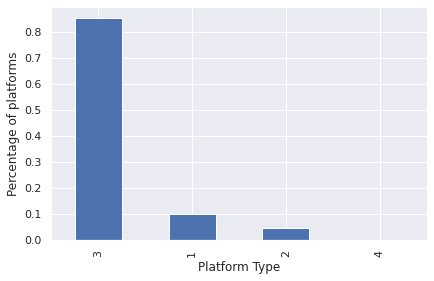

Mode platform type used: 3


In [142]:
cat_cols = ['Platform Type']
total_cols = len(training_df)

for col in cat_cols:

      temp_df = pd.Series(training_df[col].value_counts() / total_cols)
      fig = temp_df.sort_values(ascending=False).plot.bar()
      fig.set_xlabel(col)
      print(temp_df)

      fig.set_ylabel('Percentage of platforms')
      plt.show()
print('Mode platform type used:',training_df['Platform Type'].mode()[0]) 

#Personal or Business analysis

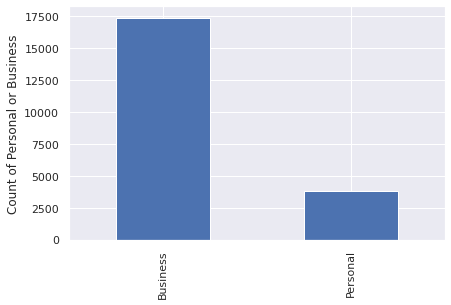

In [143]:
cat_cols = ['Personal or Business']

for col in cat_cols:

  order_df = pd.Series(training_df[col].value_counts())
  fig = order_df.sort_index().plot.bar()
  #fig.set_xlabel(col)
  fig.set_ylabel('Count of Personal or Business')
  plt.show()

#Order analysis

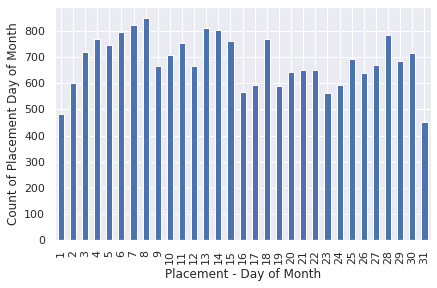

Mode day of month of placement: 8


In [144]:
cat_cols = ['Placement - Day of Month']

for col in cat_cols:

  order_df = pd.Series(training_df[col].value_counts())
  fig = order_df.sort_index().plot.bar()
  fig.set_xlabel(col)
  fig.set_ylabel('Count of Placement Day of Month')
  plt.show()

print('Mode day of month of placement:',training_df['Placement - Day of Month'].mode()[0]) 

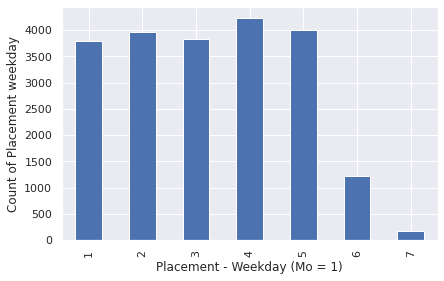

Mode weekday of placement: 4


In [145]:
#Day of week with most orders placed
cat_cols = ['Placement - Weekday (Mo = 1)']

for col in cat_cols:

  order_df = pd.Series(training_df[col].value_counts())
  fig = order_df.sort_index().plot.bar()
  fig.set_xlabel(col)
  fig.set_ylabel('Count of Placement weekday')
  plt.show()

print('Mode weekday of placement:',training_df['Placement - Weekday (Mo = 1)'].mode()[0]) 

Extracting hours, minutes and seconds from time columns to analyse the frequency of orders placed and orders picked up by hour

In [0]:
#Extract time
time_df = training_df.copy()

#Convert to 24 hours
time_df['Placement - Time'] = pd.DatetimeIndex(time_df['Placement - Time']).time
time_df['Confirmation - Time'] = pd.DatetimeIndex(time_df['Confirmation - Time']).time
time_df['Arrival at Pickup - Time'] = pd.DatetimeIndex(time_df['Arrival at Pickup - Time']).time
time_df['Pickup - Time'] = pd.DatetimeIndex(time_df['Pickup - Time']).time

In [0]:
time_df[['Placement_Hour','Placement_Minute','Placement_Seconds']] = time_df['Placement - Time'].astype(str).str.split(':', expand=True).astype(int)
time_df[['Confirmation_Hour','Confirmation_Minute','Confirmation_Seconds']] = time_df['Confirmation - Time'].astype(str).str.split(':', expand=True).astype(int)
time_df[['Arrival_at_Pickup_Hour','Arrival_at_Pickup_Minute','Arrival_at_Pickup_Seconds']] = time_df['Arrival at Pickup - Time'].astype(str).str.split(':', expand=True).astype(int)
time_df[['Pickup_Hour','Pickup_Minute','Pickup_Seconds']] = time_df['Pickup - Time'].astype(str).str.split(':', expand=True).astype(int)

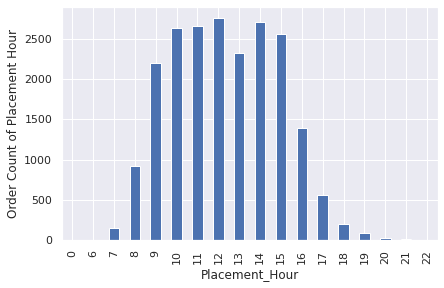

Mode hour of placement: 12


In [148]:
#Hour of day with most orders
time_cols = ['Placement_Hour']

for col in time_cols:
  
  time_eda = pd.Series(time_df[col].value_counts())
  fig = time_eda.sort_index().plot.bar()
  fig.set_xlabel(col)
  fig.set_ylabel('Order Count of Placement Hour')
  plt.show()

print('Mode hour of placement:',time_df['Placement_Hour'].mode()[0])

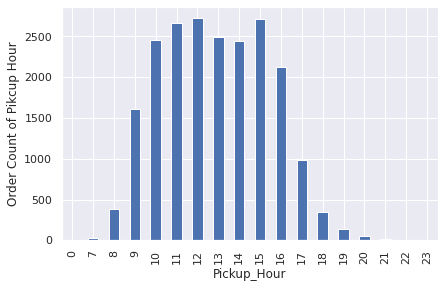

Mode hour of pickup: 12


In [149]:
#Hour of day with most pickpus
time_cols = ['Pickup_Hour']

for col in time_cols:
  
  time_eda = pd.Series(time_df[col].value_counts())
  fig = time_eda.sort_index().plot.bar()
  fig.set_xlabel(col)
  fig.set_ylabel('Order Count of Pikcup Hour')
  plt.show()

print('Mode hour of pickup:',time_df['Pickup_Hour'].mode()[0])

# Delete additional columns not releveant to model building

Order No, User Id, Platform Type - 
Does not provide any information to assist in the prediction of delivery time from picking up the package to delivery.

In [0]:
training_df = training_df.drop(['User Id', 'Platform Type'], axis = 1)

In [151]:
training_df.head()

,Order No,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_27440,Personal,18,5,3:41:17 PM,18,5,3:41:30 PM,18,5,4:07:16 PM,18,5,4:13:37 PM,18,5,5:01:43 PM,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549
2,Order_No_14170,Business,31,5,12:51:41 PM,31,5,1:12:49 PM,31,5,1:20:02 PM,31,5,1:33:08 PM,31,5,2:16:43 PM,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549
3,Order_No_21727,Personal,2,2,7:12:10 AM,2,2,7:12:29 AM,2,2,7:35:24 AM,2,2,7:38:46 AM,2,2,8:28:32 AM,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549
4,Order_No_8301,Personal,22,2,10:40:58 AM,22,2,10:42:24 AM,22,2,10:56:00 AM,22,2,10:59:40 AM,22,2,11:26:22 AM,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549


In [0]:
testing_df = testing_df.drop(['User Id', 'Platform Type'], axis = 1)

In [153]:
testing_df.head()

,Order No,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_19248,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171
1,Order_No_2699,Personal,26,2,2:43:21 PM,26,2,2:47:16 PM,26,2,3:09:26 PM,26,2,3:17:48 PM,19,-1.312745,36.875715,-1.288435,36.760677,Rider_Id_192,439,1511,13.3,171
2,Order_No_21486,Business,29,5,11:55:05 AM,29,5,11:58:12 AM,29,5,12:25:49 PM,29,5,12:28:54 PM,9,-1.255189,36.782203,-1.293393,36.790237,Rider_Id_192,439,1511,13.3,171
3,Order_No_19336,Business,2,1,9:23:21 AM,2,1,9:23:44 AM,2,1,9:44:50 AM,2,1,10:05:31 AM,15,-1.310451,36.868724,-1.259542,36.787118,Rider_Id_192,439,1511,13.3,171
4,Order_No_20374,Business,14,4,12:55:59 PM,14,4,1:22:44 PM,14,4,1:49:38 PM,14,4,1:51:49 PM,15,-1.333275,36.870815,-1.255189,36.782203,Rider_Id_192,439,1511,13.3,171


# Dummy Encoding Function

In [0]:
'''
Function that takes in a dataframe and column name
and returns new column(s) with dummy encoded variables
of given column, dropping the first dummy encoded column.
'''

def dummy_encode_columns(input_df, column_name):
    dummy_df = pd.get_dummies(input_df, columns = [column_name], drop_first = True)
    return dummy_df

Apply dummy encoding function to 'Personal or Business' column

In [0]:
#Dummy encoding on training data
training_df = dummy_encode_columns(training_df, 'Personal or Business')

In [0]:
#Dummy encoding on testing data
testing_df = dummy_encode_columns(testing_df, 'Personal or Business')

# Comparing 'Day of Month'

Determine if there is a difference between placement, confirmation, Arrival at Pickup, Pickup, Arrival at Destination. 

If 95% of data as a difference of 0 drop a column.


In [0]:
def diff_check_drop_col(df, col_1, col_2):
  diff_check_drop_col = df[col_1] - df[col_2]
  x = diff_check_drop_col.value_counts()
  if x.loc[0] > len(df.index)*0.95:
    df = df.drop([col_2], axis = 1)
  return df


In [0]:
training_df = diff_check_drop_col(training_df, "Confirmation - Day of Month", "Placement - Day of Month")

In [0]:
training_df = diff_check_drop_col(training_df, "Arrival at Pickup - Day of Month", "Confirmation - Day of Month")

In [0]:
training_df = diff_check_drop_col(training_df,"Pickup - Day of Month" ,"Arrival at Pickup - Day of Month")

In [0]:
training_df = diff_check_drop_col(training_df,'Arrival at Destination - Day of Month',"Pickup - Day of Month")

In [162]:
training_df.head()

,Order No,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal
0,Order_No_4211,5,9:35:46 AM,5,9:40:10 AM,5,10:04:47 AM,5,10:27:30 AM,9,5,10:39:55 AM,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,0
1,Order_No_27440,5,3:41:17 PM,5,3:41:30 PM,5,4:07:16 PM,5,4:13:37 PM,18,5,5:01:43 PM,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549,1
2,Order_No_14170,5,12:51:41 PM,5,1:12:49 PM,5,1:20:02 PM,5,1:33:08 PM,31,5,2:16:43 PM,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549,0
3,Order_No_21727,2,7:12:10 AM,2,7:12:29 AM,2,7:35:24 AM,2,7:38:46 AM,2,2,8:28:32 AM,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549,1
4,Order_No_8301,2,10:40:58 AM,2,10:42:24 AM,2,10:56:00 AM,2,10:59:40 AM,22,2,11:26:22 AM,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549,1


In [0]:
training_df = training_df.drop(["Arrival at Destination - Day of Month"], axis = 1)

In [164]:
training_df.head()

,Order No,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal
0,Order_No_4211,5,9:35:46 AM,5,9:40:10 AM,5,10:04:47 AM,5,10:27:30 AM,5,10:39:55 AM,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,0
1,Order_No_27440,5,3:41:17 PM,5,3:41:30 PM,5,4:07:16 PM,5,4:13:37 PM,5,5:01:43 PM,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549,1
2,Order_No_14170,5,12:51:41 PM,5,1:12:49 PM,5,1:20:02 PM,5,1:33:08 PM,5,2:16:43 PM,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549,0
3,Order_No_21727,2,7:12:10 AM,2,7:12:29 AM,2,7:35:24 AM,2,7:38:46 AM,2,8:28:32 AM,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549,1
4,Order_No_8301,2,10:40:58 AM,2,10:42:24 AM,2,10:56:00 AM,2,10:59:40 AM,2,11:26:22 AM,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549,1


#Drop all weekday columns - not relevant as all Day of Month columns were dropped

Drop: 

Placement - Weekday (Mo = 1)

Confirmation - Weekday (Mo = 1)	

Arrival at Pickup - Weekday (Mo = 1)	

Pickup - Weekday (Mo = 1)	

Arrival at Destination - Weekday (Mo = 1)	

In [0]:
training_df = training_df.drop(['Placement - Weekday (Mo = 1)','Confirmation - Weekday (Mo = 1)','Arrival at Pickup - Weekday (Mo = 1)',
                          'Pickup - Weekday (Mo = 1)','Arrival at Destination - Weekday (Mo = 1)'], axis = 1)

In [166]:
training_df.head()

,Order No,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Arrival at Destination - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal
0,Order_No_4211,9:35:46 AM,9:40:10 AM,10:04:47 AM,10:27:30 AM,10:39:55 AM,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,0
1,Order_No_27440,3:41:17 PM,3:41:30 PM,4:07:16 PM,4:13:37 PM,5:01:43 PM,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549,1
2,Order_No_14170,12:51:41 PM,1:12:49 PM,1:20:02 PM,1:33:08 PM,2:16:43 PM,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549,0
3,Order_No_21727,7:12:10 AM,7:12:29 AM,7:35:24 AM,7:38:46 AM,8:28:32 AM,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549,1
4,Order_No_8301,10:40:58 AM,10:42:24 AM,10:56:00 AM,10:59:40 AM,11:26:22 AM,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549,1


In [0]:
testing_df = testing_df.drop(['Placement - Weekday (Mo = 1)','Confirmation - Weekday (Mo = 1)','Arrival at Pickup - Weekday (Mo = 1)',
                          'Pickup - Weekday (Mo = 1)'], axis = 1)

In [0]:
testing_df = testing_df.drop(['Confirmation - Day of Month','Placement - Day of Month',"Arrival at Pickup - Day of Month",
                          'Pickup - Day of Month'], axis = 1)

In [169]:
testing_df.head()

,Order No,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal
0,Order_No_19248,4:44:10 PM,4:44:29 PM,4:53:04 PM,5:06:47 PM,8,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171,0
1,Order_No_2699,2:43:21 PM,2:47:16 PM,3:09:26 PM,3:17:48 PM,19,-1.312745,36.875715,-1.288435,36.760677,Rider_Id_192,439,1511,13.3,171,1
2,Order_No_21486,11:55:05 AM,11:58:12 AM,12:25:49 PM,12:28:54 PM,9,-1.255189,36.782203,-1.293393,36.790237,Rider_Id_192,439,1511,13.3,171,0
3,Order_No_19336,9:23:21 AM,9:23:44 AM,9:44:50 AM,10:05:31 AM,15,-1.310451,36.868724,-1.259542,36.787118,Rider_Id_192,439,1511,13.3,171,0
4,Order_No_20374,12:55:59 PM,1:22:44 PM,1:49:38 PM,1:51:49 PM,15,-1.333275,36.870815,-1.255189,36.782203,Rider_Id_192,439,1511,13.3,171,0


# Check Correlations & Change Time Format

In [170]:
correlations = training_df[training_df.columns].corr()
correlations['Time from Pickup to Arrival'].abs().sort_values()

No_of_Ratings                    0.005609
Age                              0.007969
Personal or Business_Personal    0.013354
No_Of_Orders                     0.041608
Average_Rating                   0.042559
Pickup Lat                       0.053823
Pickup Long                      0.060285
Destination Lat                  0.061872
Destination Long                 0.070425
Distance (KM)                    0.580608
Time from Pickup to Arrival      1.000000
Name: Time from Pickup to Arrival, dtype: float64

In [0]:
training_time_cols = ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 
                      'Pickup - Time', 'Arrival at Destination - Time']

for time in training_time_cols:
    training_df[time] = pd.to_datetime(training_df[time])
    

In [172]:
training_df.head()

,Order No,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Arrival at Destination - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal
0,Order_No_4211,2020-06-02 09:35:46,2020-06-02 09:40:10,2020-06-02 10:04:47,2020-06-02 10:27:30,2020-06-02 10:39:55,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,0
1,Order_No_27440,2020-06-02 15:41:17,2020-06-02 15:41:30,2020-06-02 16:07:16,2020-06-02 16:13:37,2020-06-02 17:01:43,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549,1
2,Order_No_14170,2020-06-02 12:51:41,2020-06-02 13:12:49,2020-06-02 13:20:02,2020-06-02 13:33:08,2020-06-02 14:16:43,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549,0
3,Order_No_21727,2020-06-02 07:12:10,2020-06-02 07:12:29,2020-06-02 07:35:24,2020-06-02 07:38:46,2020-06-02 08:28:32,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549,1
4,Order_No_8301,2020-06-02 10:40:58,2020-06-02 10:42:24,2020-06-02 10:56:00,2020-06-02 10:59:40,2020-06-02 11:26:22,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549,1


In [0]:
training_df['Time Difference - Placement to Confirmation'] = (training_df['Confirmation - Time'] - training_df['Placement - Time']).dt.total_seconds()

In [174]:
training_df.head()

,Order No,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Arrival at Destination - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation
0,Order_No_4211,2020-06-02 09:35:46,2020-06-02 09:40:10,2020-06-02 10:04:47,2020-06-02 10:27:30,2020-06-02 10:39:55,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,0,264.0
1,Order_No_27440,2020-06-02 15:41:17,2020-06-02 15:41:30,2020-06-02 16:07:16,2020-06-02 16:13:37,2020-06-02 17:01:43,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549,1,13.0
2,Order_No_14170,2020-06-02 12:51:41,2020-06-02 13:12:49,2020-06-02 13:20:02,2020-06-02 13:33:08,2020-06-02 14:16:43,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549,0,1268.0
3,Order_No_21727,2020-06-02 07:12:10,2020-06-02 07:12:29,2020-06-02 07:35:24,2020-06-02 07:38:46,2020-06-02 08:28:32,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549,1,19.0
4,Order_No_8301,2020-06-02 10:40:58,2020-06-02 10:42:24,2020-06-02 10:56:00,2020-06-02 10:59:40,2020-06-02 11:26:22,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549,1,86.0


In [0]:
training_df['Time Difference - Confirmation to Arrival at Pickup'] = (training_df['Arrival at Destination - Time'] - training_df['Confirmation - Time']).dt.total_seconds()

In [176]:
training_df.head()

,Order No,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Arrival at Destination - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup
0,Order_No_4211,2020-06-02 09:35:46,2020-06-02 09:40:10,2020-06-02 10:04:47,2020-06-02 10:27:30,2020-06-02 10:39:55,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,0,264.0,3585.0
1,Order_No_27440,2020-06-02 15:41:17,2020-06-02 15:41:30,2020-06-02 16:07:16,2020-06-02 16:13:37,2020-06-02 17:01:43,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549,1,13.0,4813.0
2,Order_No_14170,2020-06-02 12:51:41,2020-06-02 13:12:49,2020-06-02 13:20:02,2020-06-02 13:33:08,2020-06-02 14:16:43,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549,0,1268.0,3834.0
3,Order_No_21727,2020-06-02 07:12:10,2020-06-02 07:12:29,2020-06-02 07:35:24,2020-06-02 07:38:46,2020-06-02 08:28:32,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549,1,19.0,4563.0
4,Order_No_8301,2020-06-02 10:40:58,2020-06-02 10:42:24,2020-06-02 10:56:00,2020-06-02 10:59:40,2020-06-02 11:26:22,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549,1,86.0,2638.0


In [0]:
training_df['Time Difference - Arrival at Pickup to Pickup'] = (training_df['Pickup - Time'] - training_df['Arrival at Pickup - Time']).dt.total_seconds()

In [178]:
training_df.head()

,Order No,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Arrival at Destination - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup
0,Order_No_4211,2020-06-02 09:35:46,2020-06-02 09:40:10,2020-06-02 10:04:47,2020-06-02 10:27:30,2020-06-02 10:39:55,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,0,264.0,3585.0,1363.0
1,Order_No_27440,2020-06-02 15:41:17,2020-06-02 15:41:30,2020-06-02 16:07:16,2020-06-02 16:13:37,2020-06-02 17:01:43,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549,1,13.0,4813.0,381.0
2,Order_No_14170,2020-06-02 12:51:41,2020-06-02 13:12:49,2020-06-02 13:20:02,2020-06-02 13:33:08,2020-06-02 14:16:43,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549,0,1268.0,3834.0,786.0
3,Order_No_21727,2020-06-02 07:12:10,2020-06-02 07:12:29,2020-06-02 07:35:24,2020-06-02 07:38:46,2020-06-02 08:28:32,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549,1,19.0,4563.0,202.0
4,Order_No_8301,2020-06-02 10:40:58,2020-06-02 10:42:24,2020-06-02 10:56:00,2020-06-02 10:59:40,2020-06-02 11:26:22,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549,1,86.0,2638.0,220.0


In [0]:
training_df['Time Difference - Pickup to Arrival at Destination'] = (training_df['Arrival at Destination - Time'] - training_df['Pickup - Time']).dt.total_seconds()

In [180]:
training_df.head()

,Order No,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Arrival at Destination - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup,Time Difference - Pickup to Arrival at Destination
0,Order_No_4211,2020-06-02 09:35:46,2020-06-02 09:40:10,2020-06-02 10:04:47,2020-06-02 10:27:30,2020-06-02 10:39:55,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,0,264.0,3585.0,1363.0,745.0
1,Order_No_27440,2020-06-02 15:41:17,2020-06-02 15:41:30,2020-06-02 16:07:16,2020-06-02 16:13:37,2020-06-02 17:01:43,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549,1,13.0,4813.0,381.0,2886.0
2,Order_No_14170,2020-06-02 12:51:41,2020-06-02 13:12:49,2020-06-02 13:20:02,2020-06-02 13:33:08,2020-06-02 14:16:43,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549,0,1268.0,3834.0,786.0,2615.0
3,Order_No_21727,2020-06-02 07:12:10,2020-06-02 07:12:29,2020-06-02 07:35:24,2020-06-02 07:38:46,2020-06-02 08:28:32,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549,1,19.0,4563.0,202.0,2986.0
4,Order_No_8301,2020-06-02 10:40:58,2020-06-02 10:42:24,2020-06-02 10:56:00,2020-06-02 10:59:40,2020-06-02 11:26:22,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549,1,86.0,2638.0,220.0,1602.0


In [0]:
testing_time_cols = ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 
                      'Pickup - Time']

for time in testing_time_cols:
    testing_df[time] = pd.to_datetime(testing_df[time])

In [0]:
testing_df['Time Difference - Placement to Confirmation'] = (testing_df['Confirmation - Time'] - testing_df['Placement - Time']).dt.total_seconds()

In [0]:
testing_df['Time Difference - Confirmation to Arrival at Pickup'] = (testing_df['Arrival at Pickup - Time'] - testing_df['Confirmation - Time']).dt.total_seconds()

In [0]:
testing_df['Time Difference - Arrival at Pickup to Pickup'] = (testing_df['Pickup - Time'] - testing_df['Arrival at Pickup - Time']).dt.total_seconds()

In [185]:
testing_df.head()

,Order No,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup
0,Order_No_19248,2020-06-02 16:44:10,2020-06-02 16:44:29,2020-06-02 16:53:04,2020-06-02 17:06:47,8,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171,0,19.0,515.0,823.0
1,Order_No_2699,2020-06-02 14:43:21,2020-06-02 14:47:16,2020-06-02 15:09:26,2020-06-02 15:17:48,19,-1.312745,36.875715,-1.288435,36.760677,Rider_Id_192,439,1511,13.3,171,1,235.0,1330.0,502.0
2,Order_No_21486,2020-06-02 11:55:05,2020-06-02 11:58:12,2020-06-02 12:25:49,2020-06-02 12:28:54,9,-1.255189,36.782203,-1.293393,36.790237,Rider_Id_192,439,1511,13.3,171,0,187.0,1657.0,185.0
3,Order_No_19336,2020-06-02 09:23:21,2020-06-02 09:23:44,2020-06-02 09:44:50,2020-06-02 10:05:31,15,-1.310451,36.868724,-1.259542,36.787118,Rider_Id_192,439,1511,13.3,171,0,23.0,1266.0,1241.0
4,Order_No_20374,2020-06-02 12:55:59,2020-06-02 13:22:44,2020-06-02 13:49:38,2020-06-02 13:51:49,15,-1.333275,36.870815,-1.255189,36.782203,Rider_Id_192,439,1511,13.3,171,0,1605.0,1614.0,131.0


# Drop Time columns

Drop the following columns:

Placement - Time

Confirmation - Time

Arrival at Pickup - Time	

Pickup - Time	

Arrival at Destination - Time	

In [0]:
training_df = training_df.drop(['Placement - Time', 'Confirmation - Time', 
                                'Arrival at Pickup - Time', 'Pickup - Time', 
                                'Arrival at Destination - Time'], axis = 1)

In [187]:
training_df.head()

,Order No,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup,Time Difference - Pickup to Arrival at Destination
0,Order_No_4211,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,0,264.0,3585.0,1363.0,745.0
1,Order_No_27440,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549,1,13.0,4813.0,381.0,2886.0
2,Order_No_14170,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549,0,1268.0,3834.0,786.0,2615.0
3,Order_No_21727,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549,1,19.0,4563.0,202.0,2986.0
4,Order_No_8301,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549,1,86.0,2638.0,220.0,1602.0


In [0]:
testing_df = testing_df.drop(['Placement - Time', 'Confirmation - Time', 
                                'Arrival at Pickup - Time', 'Pickup - Time'], axis = 1)

In [189]:
testing_df.head()

,Order No,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup
0,Order_No_19248,8,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171,0,19.0,515.0,823.0
1,Order_No_2699,19,-1.312745,36.875715,-1.288435,36.760677,Rider_Id_192,439,1511,13.3,171,1,235.0,1330.0,502.0
2,Order_No_21486,9,-1.255189,36.782203,-1.293393,36.790237,Rider_Id_192,439,1511,13.3,171,0,187.0,1657.0,185.0
3,Order_No_19336,15,-1.310451,36.868724,-1.259542,36.787118,Rider_Id_192,439,1511,13.3,171,0,23.0,1266.0,1241.0
4,Order_No_20374,15,-1.333275,36.870815,-1.255189,36.782203,Rider_Id_192,439,1511,13.3,171,0,1605.0,1614.0,131.0


In [190]:
correlations = training_df[training_df.columns].corr()
correlations['Time from Pickup to Arrival'].abs().sort_values()

No_of_Ratings                                          0.005609
Age                                                    0.007969
Personal or Business_Personal                          0.013354
Time Difference - Placement to Confirmation            0.035489
No_Of_Orders                                           0.041608
Average_Rating                                         0.042559
Pickup Lat                                             0.053823
Pickup Long                                            0.060285
Destination Lat                                        0.061872
Destination Long                                       0.070425
Time Difference - Arrival at Pickup to Pickup          0.079637
Distance (KM)                                          0.580608
Time Difference - Confirmation to Arrival at Pickup    0.732104
Time from Pickup to Arrival                            1.000000
Time Difference - Pickup to Arrival at Destination     1.000000
Name: Time from Pickup to Arrival, dtype

In [0]:
training_df = training_df.drop(['Time Difference - Pickup to Arrival at Destination'], axis = 1)

In [192]:
training_df.head()

,Order No,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup
0,Order_No_4211,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,0,264.0,3585.0,1363.0
1,Order_No_27440,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549,1,13.0,4813.0,381.0
2,Order_No_14170,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549,0,1268.0,3834.0,786.0
3,Order_No_21727,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549,1,19.0,4563.0,202.0
4,Order_No_8301,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549,1,86.0,2638.0,220.0


##Harvesine Distance - Converting Longitude/Latitude to a value

In [0]:
def haversine(lat1, lon1, lat2, lon2, to_radians = True, earth_radius = 6371):
    """
    Modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


training_df['Distance'] = haversine(training_df['Pickup Lat'], 
                                training_df['Pickup Long'],
                                training_df['Destination Lat'], 
                                training_df['Destination Long'])

In [194]:
training_df.head()

,Order No,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup,Distance
0,Order_No_4211,4,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,0,264.0,3585.0,1363.0,1.930333
1,Order_No_27440,20,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,2886,1637,1309,13.8,549,1,13.0,4813.0,381.0,13.357387
2,Order_No_14170,6,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,2615,1637,1309,13.8,549,0,1268.0,3834.0,786.0,4.485987
3,Order_No_21727,18,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,2986,1637,1309,13.8,549,1,19.0,4563.0,202.0,8.935273
4,Order_No_8301,7,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1602,1637,1309,13.8,549,1,86.0,2638.0,220.0,6.000848


In [0]:
testing_df['Distance'] = haversine(testing_df['Pickup Lat'], 
                                testing_df['Pickup Long'],
                                testing_df['Destination Lat'], 
                                testing_df['Destination Long'])

In [196]:
testing_df.head()

,Order No,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup,Distance
0,Order_No_19248,8,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171,0,19.0,515.0,823.0,6.220125
1,Order_No_2699,19,-1.312745,36.875715,-1.288435,36.760677,Rider_Id_192,439,1511,13.3,171,1,235.0,1330.0,502.0,13.070949
2,Order_No_21486,9,-1.255189,36.782203,-1.293393,36.790237,Rider_Id_192,439,1511,13.3,171,0,187.0,1657.0,185.0,4.340897
3,Order_No_19336,15,-1.310451,36.868724,-1.259542,36.787118,Rider_Id_192,439,1511,13.3,171,0,23.0,1266.0,1241.0,10.693117
4,Order_No_20374,15,-1.333275,36.870815,-1.255189,36.782203,Rider_Id_192,439,1511,13.3,171,0,1605.0,1614.0,131.0,13.131026


# Change Rider ID to only be a code

In [0]:
def extract_id(input_df):
    input_df['Rider Id'] = input_df['Rider Id'].str.extract(r"([0-9]+)").astype(int)
    return input_df


In [198]:
extract_id(training_df)

,Order No,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup,Distance
0,Order_No_4211,4,-1.317755,36.830370,-1.300406,36.829741,432,745,1637,1309,13.8,549,0,264.0,3585.0,1363.0,1.930333
1,Order_No_27440,20,-1.326774,36.787807,-1.356237,36.904295,432,2886,1637,1309,13.8,549,1,13.0,4813.0,381.0,13.357387
2,Order_No_14170,6,-1.255189,36.782203,-1.273412,36.818206,432,2615,1637,1309,13.8,549,0,1268.0,3834.0,786.0,4.485987
3,Order_No_21727,18,-1.290315,36.757377,-1.223520,36.802061,432,2986,1637,1309,13.8,549,1,19.0,4563.0,202.0,8.935273
4,Order_No_8301,7,-1.273524,36.799220,-1.300431,36.752427,432,1602,1637,1309,13.8,549,1,86.0,2638.0,220.0,6.000848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21196,Order_No_27103,3,-1.265003,36.812624,-1.265432,36.795034,528,919,5770,1793,14.2,2205,0,1361.0,2149.0,196.0,1.956047
21197,Order_No_3786,6,-1.269609,36.825741,-1.278067,36.783487,638,2331,102,873,13.7,32,1,850.0,3737.0,1072.0,4.790511
21198,Order_No_7281,7,-1.250823,36.789526,-1.285850,36.830629,773,2418,5,105,0.0,0,0,641.0,5774.0,373.0,6.004046
21199,Order_No_15575,2,-1.291787,36.787267,-1.298575,36.808800,860,717,5,448,15.0,2,0,48.0,1657.0,178.0,2.509879


In [199]:
extract_id(testing_df)

,Order No,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup,Distance
0,Order_No_19248,8,-1.333275,36.870815,-1.305249,36.822390,192,439,1511,13.3,171,0,19.0,515.0,823.0,6.220125
1,Order_No_2699,19,-1.312745,36.875715,-1.288435,36.760677,192,439,1511,13.3,171,1,235.0,1330.0,502.0,13.070949
2,Order_No_21486,9,-1.255189,36.782203,-1.293393,36.790237,192,439,1511,13.3,171,0,187.0,1657.0,185.0,4.340897
3,Order_No_19336,15,-1.310451,36.868724,-1.259542,36.787118,192,439,1511,13.3,171,0,23.0,1266.0,1241.0,10.693117
4,Order_No_20374,15,-1.333275,36.870815,-1.255189,36.782203,192,439,1511,13.3,171,0,1605.0,1614.0,131.0,13.131026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7063,Order_No_5207,8,-1.300921,36.828195,-1.272807,36.796236,738,2849,2506,14.2,427,0,2808.0,1074.0,2708.0,4.732324
7064,Order_No_11108,24,-1.316959,36.700003,-1.276574,36.851365,443,3504,2234,14.6,1086,0,549.0,358.0,877.0,17.415276
7065,Order_No_15696,11,-1.303596,36.778378,-1.330611,36.848052,176,417,136,12.8,34,0,436.0,225.0,370.0,8.307490
7066,Order_No_14332,19,-1.300921,36.828195,-1.319862,36.711032,181,34,291,15.0,5,0,34.0,446.0,2107.0,13.193671


## Target variable distribution

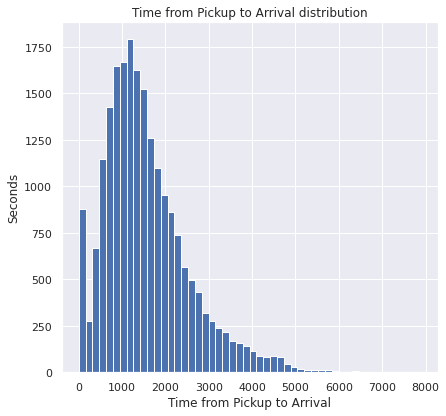

In [200]:
# Histogram of the Time from Pickup to Arrival

figsize(6, 6)
plt.hist(training_df['Time from Pickup to Arrival'].dropna(), bins = 50);
plt.xlabel('Time from Pickup to Arrival'); plt.ylabel('Seconds'); 
plt.title('Time from Pickup to Arrival distribution');

In [201]:
training_df['Time from Pickup to Arrival'].describe()


count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time from Pickup to Arrival, dtype: float64

Outlier - A substantial amount of deliveries seems to have been done in just seconds. Comparing min, max and mean

In [202]:
training_df['Distance (KM)'].describe()

count    21201.000000
mean         9.506533
std          5.668963
min          1.000000
25%          5.000000
50%          8.000000
75%         13.000000
max         49.000000
Name: Distance (KM), dtype: float64

##Target transformation

Create Speed column

In [203]:
training_df['Speed (KM/H)'] = training_df['Distance (KM)']/(training_df['Time from Pickup to Arrival']/3600)
training_df.head()

,Order No,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup,Distance,Speed (KM/H)
0,Order_No_4211,4,-1.317755,36.830370,-1.300406,36.829741,432,745,1637,1309,13.8,549,0,264.0,3585.0,1363.0,1.930333,19.328859
1,Order_No_27440,20,-1.326774,36.787807,-1.356237,36.904295,432,2886,1637,1309,13.8,549,1,13.0,4813.0,381.0,13.357387,24.948025
2,Order_No_14170,6,-1.255189,36.782203,-1.273412,36.818206,432,2615,1637,1309,13.8,549,0,1268.0,3834.0,786.0,4.485987,8.260038
3,Order_No_21727,18,-1.290315,36.757377,-1.223520,36.802061,432,2986,1637,1309,13.8,549,1,19.0,4563.0,202.0,8.935273,21.701273
4,Order_No_8301,7,-1.273524,36.799220,-1.300431,36.752427,432,1602,1637,1309,13.8,549,1,86.0,2638.0,220.0,6.000848,15.730337


In [204]:
training_df['Speed (KM/H)'].describe()

count    21201.000000
mean       249.305379
std       1905.297307
min          0.920245
25%         16.463415
50%         23.064602
75%         30.288462
max      61200.000000
Name: Speed (KM/H), dtype: float64

Check how many orders took less than 60 seconds to deliver

In [205]:
training_df[(training_df['Time from Pickup to Arrival'] < 60)].count()   

Order No                                               740
Distance (KM)                                          740
Pickup Lat                                             740
Pickup Long                                            740
Destination Lat                                        740
Destination Long                                       740
Rider Id                                               740
Time from Pickup to Arrival                            740
No_Of_Orders                                           740
Age                                                    740
Average_Rating                                         740
No_of_Ratings                                          740
Personal or Business_Personal                          740
Time Difference - Placement to Confirmation            740
Time Difference - Confirmation to Arrival at Pickup    740
Time Difference - Arrival at Pickup to Pickup          740
Distance                                               7

Check how many orders were delivered at a speed of more than 80km/h

In [206]:
training_df[(training_df['Speed (KM/H)'] > 80)].count()

Order No                                               966
Distance (KM)                                          966
Pickup Lat                                             966
Pickup Long                                            966
Destination Lat                                        966
Destination Long                                       966
Rider Id                                               966
Time from Pickup to Arrival                            966
No_Of_Orders                                           966
Age                                                    966
Average_Rating                                         966
No_of_Ratings                                          966
Personal or Business_Personal                          966
Time Difference - Placement to Confirmation            966
Time Difference - Confirmation to Arrival at Pickup    966
Time Difference - Arrival at Pickup to Pickup          966
Distance                                               9

Plot a histogram based on Speed Distribution

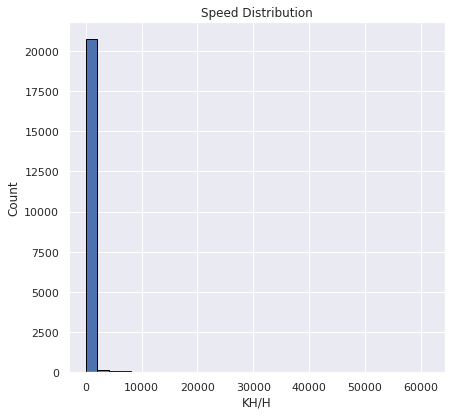

In [207]:
figsize(6, 6)
plt.hist(training_df['Speed (KM/H)'], bins = 30, edgecolor = 'black');
plt.xlabel('KH/H');
plt.ylabel('Count'); plt.title('Speed Distribution');

Not a normal distribution. Create a new dataframe based only on rows with speed no more than 80km/h

In [0]:
speed_df = training_df[(training_df['Speed (KM/H)'] <= 80)] 

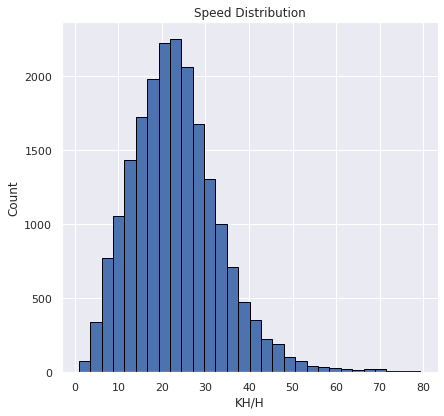

In [209]:
figsize(6, 6)
plt.hist(speed_df['Speed (KM/H)'], bins = 30, edgecolor = 'black');
plt.xlabel('KH/H');
plt.ylabel('Count'); plt.title('Speed Distribution');

In [210]:
speed_df['Speed (KM/H)'].describe()

count    20235.000000
mean        23.256192
std         10.281375
min          0.920245
25%         16.100179
50%         22.471910
75%         29.010812
max         79.370079
Name: Speed (KM/H), dtype: float64

Check how many rows are left with a delivery time of less than 60 seconds

In [211]:
speed_df[(speed_df['Time from Pickup to Arrival'] < 60)].count()   

Order No                                               0
Distance (KM)                                          0
Pickup Lat                                             0
Pickup Long                                            0
Destination Lat                                        0
Destination Long                                       0
Rider Id                                               0
Time from Pickup to Arrival                            0
No_Of_Orders                                           0
Age                                                    0
Average_Rating                                         0
No_of_Ratings                                          0
Personal or Business_Personal                          0
Time Difference - Placement to Confirmation            0
Time Difference - Confirmation to Arrival at Pickup    0
Time Difference - Arrival at Pickup to Pickup          0
Distance                                               0
Speed (KM/H)                   

Speed_df represents data with outliers removed

In [212]:
speed_df.head()

,Order No,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup,Distance,Speed (KM/H)
0,Order_No_4211,4,-1.317755,36.830370,-1.300406,36.829741,432,745,1637,1309,13.8,549,0,264.0,3585.0,1363.0,1.930333,19.328859
1,Order_No_27440,20,-1.326774,36.787807,-1.356237,36.904295,432,2886,1637,1309,13.8,549,1,13.0,4813.0,381.0,13.357387,24.948025
2,Order_No_14170,6,-1.255189,36.782203,-1.273412,36.818206,432,2615,1637,1309,13.8,549,0,1268.0,3834.0,786.0,4.485987,8.260038
3,Order_No_21727,18,-1.290315,36.757377,-1.223520,36.802061,432,2986,1637,1309,13.8,549,1,19.0,4563.0,202.0,8.935273,21.701273
4,Order_No_8301,7,-1.273524,36.799220,-1.300431,36.752427,432,1602,1637,1309,13.8,549,1,86.0,2638.0,220.0,6.000848,15.730337


In [213]:
speed_df.columns

Index(['Order No', 'Distance (KM)', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival', 'No_Of_Orders', 'Age', 'Average_Rating',
       'No_of_Ratings', 'Personal or Business_Personal',
       'Time Difference - Placement to Confirmation',
       'Time Difference - Confirmation to Arrival at Pickup',
       'Time Difference - Arrival at Pickup to Pickup', 'Distance',
       'Speed (KM/H)'],
      dtype='object')

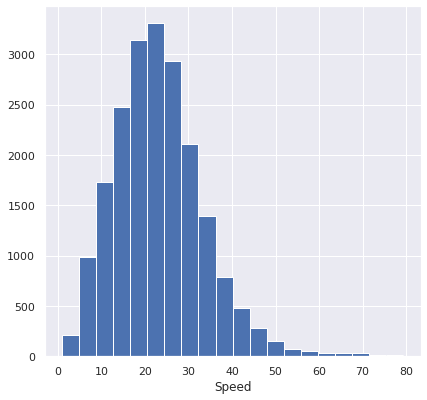

Mean speed: 23.26 km/h


In [214]:
#Speed interval distribution

plt.hist(speed_df['Speed (KM/H)'], bins=20)
plt.xlabel('Speed')
plt.show()

print('Mean speed:',round(speed_df['Speed (KM/H)'].mean(),2), 'km/h')

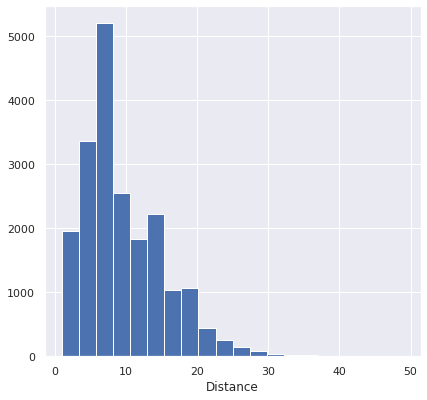

Mean distance: 9.61097108969607


In [215]:
#Distance interval distribution

plt.hist(speed_df['Distance (KM)'], bins=20)
plt.xlabel('Distance')
plt.show()

print('Mean distance:',speed_df['Distance (KM)'].mean())

In [216]:
speed_df.head()

,Order No,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup,Distance,Speed (KM/H)
0,Order_No_4211,4,-1.317755,36.830370,-1.300406,36.829741,432,745,1637,1309,13.8,549,0,264.0,3585.0,1363.0,1.930333,19.328859
1,Order_No_27440,20,-1.326774,36.787807,-1.356237,36.904295,432,2886,1637,1309,13.8,549,1,13.0,4813.0,381.0,13.357387,24.948025
2,Order_No_14170,6,-1.255189,36.782203,-1.273412,36.818206,432,2615,1637,1309,13.8,549,0,1268.0,3834.0,786.0,4.485987,8.260038
3,Order_No_21727,18,-1.290315,36.757377,-1.223520,36.802061,432,2986,1637,1309,13.8,549,1,19.0,4563.0,202.0,8.935273,21.701273
4,Order_No_8301,7,-1.273524,36.799220,-1.300431,36.752427,432,1602,1637,1309,13.8,549,1,86.0,2638.0,220.0,6.000848,15.730337


#Correlations

Filter features based on correlation matrix outcomes

In [0]:
#Reorder columns
speed_df = speed_df.filter(['Order No','Pickup Lat', 'Pickup Long', 'Destination Lat',
       'Destination Long', 'Distance (KM)', 'Rider Id',
       'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings',
       'Personal or Business_Personal',
       'Time Difference - Placement to Confirmation',
       'Time Difference - Confirmation to Arrival at Pickup',
       'Time Difference - Arrival at Pickup to Pickup', 'Distance',
       'Speed (KM/H)', 'Time from Pickup to Arrival'], axis=1)

In [218]:
correlations = speed_df.corr()
correlations = correlations['Time from Pickup to Arrival'].abs().sort_values()
print(correlations)

No_Of_Orders                                           0.007118
No_of_Ratings                                          0.008706
Rider Id                                               0.010426
Personal or Business_Personal                          0.016847
Time Difference - Arrival at Pickup to Pickup          0.021847
Age                                                    0.022489
Time Difference - Placement to Confirmation            0.031138
Destination Lat                                        0.064913
Average_Rating                                         0.066536
Pickup Lat                                             0.070665
Destination Long                                       0.072310
Pickup Long                                            0.074356
Speed (KM/H)                                           0.332809
Distance                                               0.579502
Distance (KM)                                          0.596230
Time Difference - Confirmation to Arriva

Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

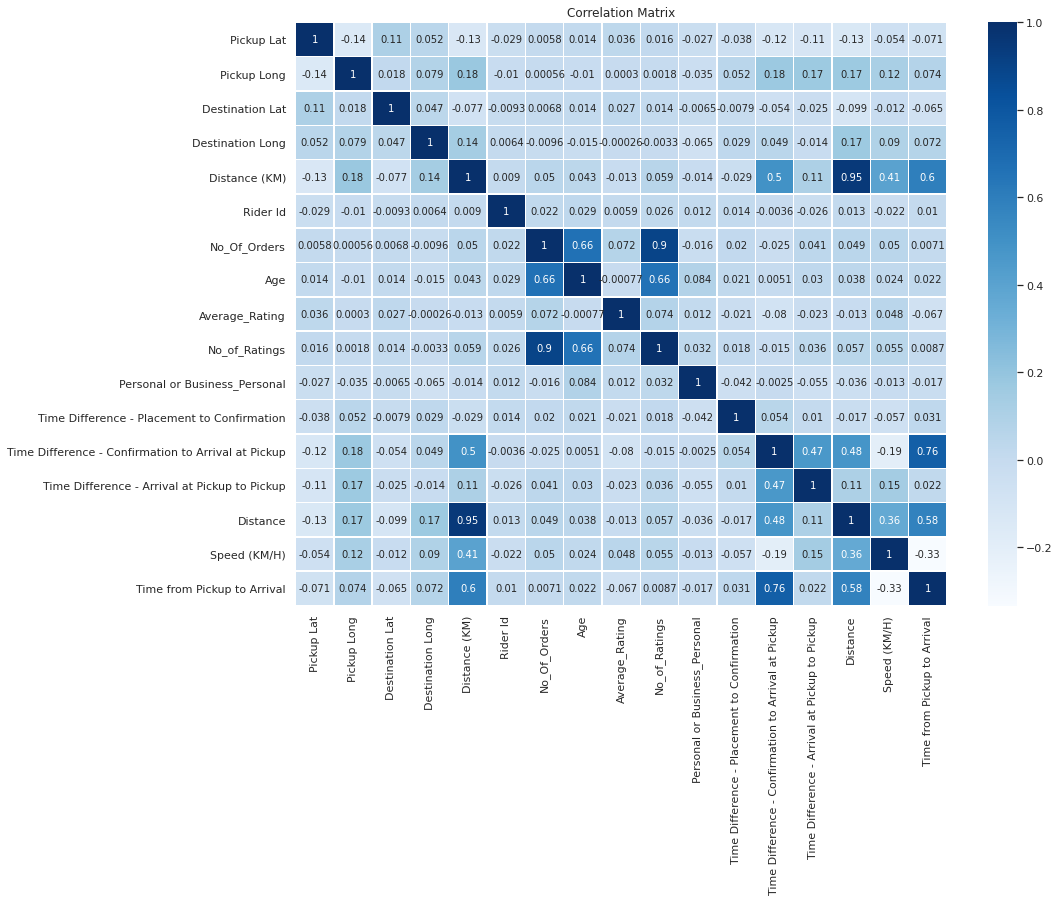

In [219]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(speed_df.corr(), annot=True, annot_kws={'fontsize':10}, linewidths=.5,cmap='Blues', ax=ax, )
plt.title('Correlation Matrix')

##Remove collinearity
Remove features that are highly correlated - Based on above correlation matrix, dropping the following columns with correlation greater than 0.6:


In [0]:
final_features = speed_df.drop(['Distance', 'Time Difference - Confirmation to Arrival at Pickup', 'No_of_Ratings', 'No_Of_Orders'], axis=1)

In [221]:
final_features.columns

Index(['Order No', 'Pickup Lat', 'Pickup Long', 'Destination Lat',
       'Destination Long', 'Distance (KM)', 'Rider Id', 'Age',
       'Average_Rating', 'Personal or Business_Personal',
       'Time Difference - Placement to Confirmation',
       'Time Difference - Arrival at Pickup to Pickup', 'Speed (KM/H)',
       'Time from Pickup to Arrival'],
      dtype='object')

Text(0.5, 1.0, 'Correlation Matrix')

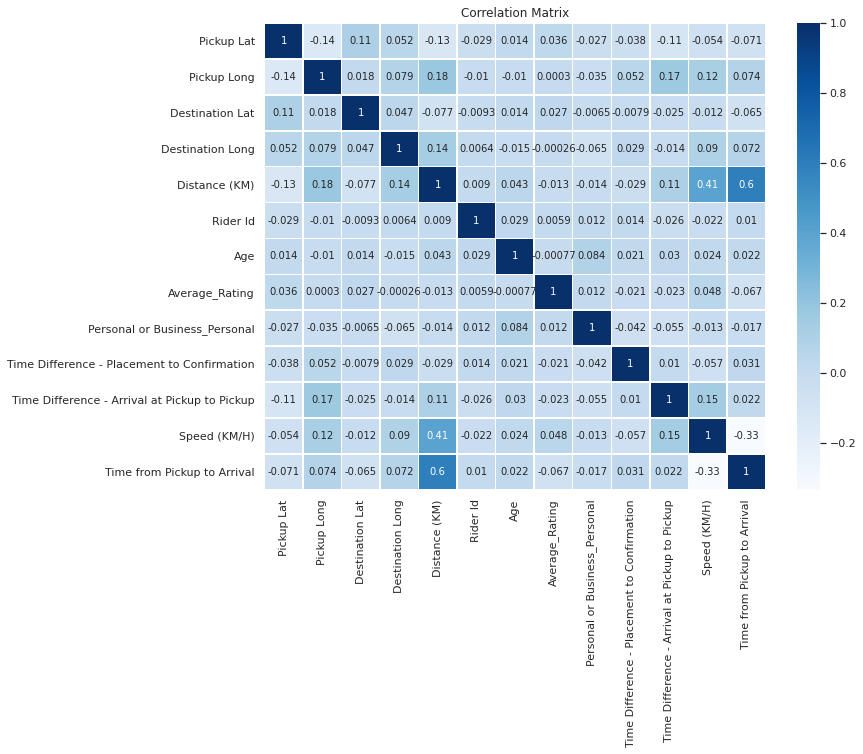

In [222]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(final_features.corr(), annot=True, annot_kws={'fontsize':10}, linewidths=.5,cmap='Blues', ax=ax)
plt.title('Correlation Matrix')

Update Testing DataFrame accordingly

In [223]:
testing_df.head()

,Order No,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal,Time Difference - Placement to Confirmation,Time Difference - Confirmation to Arrival at Pickup,Time Difference - Arrival at Pickup to Pickup,Distance
0,Order_No_19248,8,-1.333275,36.870815,-1.305249,36.822390,192,439,1511,13.3,171,0,19.0,515.0,823.0,6.220125
1,Order_No_2699,19,-1.312745,36.875715,-1.288435,36.760677,192,439,1511,13.3,171,1,235.0,1330.0,502.0,13.070949
2,Order_No_21486,9,-1.255189,36.782203,-1.293393,36.790237,192,439,1511,13.3,171,0,187.0,1657.0,185.0,4.340897
3,Order_No_19336,15,-1.310451,36.868724,-1.259542,36.787118,192,439,1511,13.3,171,0,23.0,1266.0,1241.0,10.693117
4,Order_No_20374,15,-1.333275,36.870815,-1.255189,36.782203,192,439,1511,13.3,171,0,1605.0,1614.0,131.0,13.131026


In [0]:
testing_df = testing_df.drop(['Distance', 'Time Difference - Confirmation to Arrival at Pickup', 'No_of_Ratings', 'No_Of_Orders'], axis=1)


In [0]:
#Rearrange columns
final_features = final_features.filter(['Order No', 'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id', 'Age', 'Average_Rating',
       'Time Difference - Placement to Confirmation',
       'Time Difference - Arrival at Pickup to Pickup', 
       'Distance (KM)', 'Speed (KM/H)', 'Time from Pickup to Arrival'], axis=1)

In [0]:
#Drop Speed (KM/H) column not in testing_df
final_features = final_features.drop('Speed (KM/H)', axis=1)

##Split into Training and Testing sets
Using train_test_split

In [227]:
X = final_features.drop(columns='Time from Pickup to Arrival')
X = X.iloc[:, 1:]
y = pd.DataFrame(final_features['Time from Pickup to Arrival'])


# Split into 80% training and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(list(final_features.columns))

(16188, 10)
(4047, 10)
(16188, 1)
(4047, 1)
['Order No', 'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long', 'Rider Id', 'Age', 'Average_Rating', 'Time Difference - Placement to Confirmation', 'Time Difference - Arrival at Pickup to Pickup', 'Distance (KM)', 'Time from Pickup to Arrival']


##Scale features
Scale features using MinMaxScaler

In [0]:
mms = MinMaxScaler(feature_range=(0, 1))
mms.fit(X_train)
X_train = mms.transform(X_train)
X_test = mms.transform(X_test)

In [229]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16188, 10)
(4047, 10)
(16188, 1)
(4047, 1)


Change scaling for y (Train & Test)

In [0]:
y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

##Base Models

In [0]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_test)**2))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_rmse = rmse(y_test, model_pred)
    
    y_pred = model.predict(X_test)
    
    # Return the performance metric
    print('RMSE =', round(model_rmse,4), '| R_squared =', metrics.r2_score(y_test, y_pred))

In [232]:
#Linear Regression
lr = LinearRegression()
lr_rmse = fit_and_evaluate(lr)


RMSE = 738.5885 | R_squared = 0.37739420111862554


In [233]:
#Lasso regression
lasso = Lasso()
lasso_rmse = fit_and_evaluate(lasso)

RMSE = 738.8629 | R_squared = 0.3769315559288988


In [234]:
#Ridge regression
ridge = Ridge()
ridge_rmse = fit_and_evaluate(ridge)


RMSE = 738.5532 | R_squared = 0.3774538239772651


In [235]:
#Decision tree
dec_tree = DecisionTreeRegressor(max_depth=3)
dec_tree_rmse = fit_and_evaluate(dec_tree)


RMSE = 742.3893 | R_squared = 0.37096989005176484


In [236]:
#Random Forest
random_forest = RandomForestRegressor()
random_forest_rmse = fit_and_evaluate(random_forest)


RMSE = 725.7258 | R_squared = 0.39889114168462203


In [237]:
#Gradient boosted
gradient_boosted = GradientBoostingRegressor()
gradient_boosted_rmse = fit_and_evaluate(gradient_boosted)


RMSE = 715.0316 | R_squared = 0.4164762655471703


In [238]:
#Catboost
catboost = CatBoostRegressor(logging_level='Silent')
catboost_rmse = fit_and_evaluate(catboost)


RMSE = 695.433 | R_squared = 0.44802603697319865


## Applying CatBoostRegressor(Train Test Split) with default parameters to testing data for Zindi submission

In [0]:
feature_cols = ['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long', 
                'Rider Id', 'Age', 'Average_Rating', 'Time Difference - Placement to Confirmation', 
                'Time Difference - Arrival at Pickup to Pickup', 'Distance (KM)']
cat_boost = CatBoostRegressor(logging_level='Silent')
cat_boost.fit(final_features[feature_cols], final_features['Time from Pickup to Arrival'])
testing_df['Time from Pickup to Arrival'] = cat_boost.predict(testing_df[feature_cols])
testing_df['Time from Pickup to Arrival'] = round(testing_df['Time from Pickup to Arrival'])

In [0]:
submission = testing_df[['Order No', 'Time from Pickup to Arrival']]
submission = submission.rename(columns={'Order No':'Order_No'})

#Uncomment to download CSV
#submission.to_csv('ZindiSubmission_1.csv', index=False)
#files.download('ZindiSubmission_1.csv')

#KFold

In [0]:
'''
The function takes in features columns of the dataset to be trained
and validated as well as model type. Function splits data, calculates
RMSE of training and testing set and returns RMSE score of training and
testing set for comparison.
'''

def train_and_validate(columns, model):
     features = final_features[columns]
     target = final_features['Time from Pickup to Arrival']
     
     train_mses = []
     train_rmses = []
     test_mses = []
     test_rmses = []

     folds = KFold(n_splits=10, shuffle=True)

     for train_index, test_index in folds.split(features):
          x_train, x_test = features.iloc[train_index], features.iloc[test_index]    
          y_train, y_test = target.iloc[train_index], target.iloc[test_index]
     
          model.fit(x_train, y_train)
          train_predictions = model.predict(x_train)
          test_predictions = model.predict(x_test)
     
          train_mse = mean_squared_error(y_train, train_predictions)
          train_rmse = train_mse**0.5
          train_mses.append(train_mse)
          train_rmses.append(train_rmse)
     
          test_mse = mean_squared_error(y_test, test_predictions)
          test_rmse = test_mse**0.5
          test_mses.append(test_mse)
          test_rmses.append(test_rmse)
    
     
     avg_train_rmse = np.mean(train_rmses)
     avg_test_rmse = np.mean(test_rmses)

     return [avg_train_rmse, avg_test_rmse]

In [242]:
#Selecting features for train_validate function
features = final_features.drop(['Time from Pickup to Arrival', 'Rider Id'], axis=1)
features = features.columns
features

Index(['Order No', 'Pickup Lat', 'Pickup Long', 'Destination Lat',
       'Destination Long', 'Age', 'Average_Rating',
       'Time Difference - Placement to Confirmation',
       'Time Difference - Arrival at Pickup to Pickup', 'Distance (KM)'],
      dtype='object')

In [243]:
final_features.shape

(20235, 12)

In [244]:
#Select the first 2 features to train model
print(features[1:3])
print('Linear:',train_and_validate(features[1:3], lr))
print('Lasso:',train_and_validate(features[1:3], lasso))
print('Ridge:',train_and_validate(features[1:3], ridge))
print('Decision tree:',train_and_validate(features[1:3], dec_tree))
print('Random Forest:',train_and_validate(features[1:3], random_forest))
print('Gradient Boosted:',train_and_validate(features[1:3], gradient_boosted))
print('Catboost:',train_and_validate(features[1:3], catboost))


Index(['Pickup Lat', 'Pickup Long'], dtype='object')
Linear: [949.1322318631576, 949.1036279319103]
Lasso: [949.936743545359, 949.2611206608992]
Ridge: [949.1314354644467, 949.0021708342204]
Decision tree: [920.6713141099402, 922.706180073541]
Random Forest: [814.0173918646955, 929.1308059644682]
Gradient Boosted: [895.5493726436646, 907.5315981517845]
Catboost: [871.7173030395328, 905.3693560830527]


In [245]:
#Select the first 4 features to train model
print(features[1:5])
print('Linear:',train_and_validate(features[1:5], lr))
print('Lasso:',train_and_validate(features[1:5], lasso))
print('Ridge:',train_and_validate(features[1:5], ridge))
print('Decision tree:',train_and_validate(features[1:5], dec_tree))
print('Random Forest:',train_and_validate(features[1:5], random_forest))
print('Gradient Boosted:',train_and_validate(features[1:5], gradient_boosted))
print('Catboost:',train_and_validate(features[1:5], catboost))


Index(['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long'], dtype='object')
Linear: [944.8324364172756, 944.9032077433785]
Lasso: [946.2908589975912, 946.3160161249332]
Ridge: [944.8415736356219, 944.7870455698583]
Decision tree: [887.0852128482329, 892.829896080368]
Random Forest: [463.1905716315179, 794.7260613686103]
Gradient Boosted: [758.1596948387437, 773.6558339198286]
Catboost: [678.3158450397326, 750.4060161391586]


In [246]:
#Select the first 6 features to train model
print(features[1:7])
print('Linear:',train_and_validate(features[1:7], lr))
print('Lasso:',train_and_validate(features[1:7], lasso))
print('Ridge:',train_and_validate(features[1:7], ridge))
print('Decision tree:',train_and_validate(features[1:7], dec_tree))
print('Random Forest:',train_and_validate(features[1:7], random_forest))
print('Gradient Boosted:',train_and_validate(features[1:7], gradient_boosted))
print('Catboost:',train_and_validate(features[1:7], catboost))


Index(['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Age', 'Average_Rating'],
      dtype='object')
Linear: [942.599331961779, 943.2059472128431]
Lasso: [944.0688691833035, 944.2687138345216]
Ridge: [942.6132744467862, 943.083737176247]
Decision tree: [887.3988992883636, 891.823330852457]
Random Forest: [296.98100815309704, 766.4791510792656]
Gradient Boosted: [754.3351275485534, 773.6823583040858]
Catboost: [637.7230123298367, 733.9490034002654]


In [247]:
#Select the first 8 features to train model
print(features[1:9])
print('Linear:',train_and_validate(features[1:9], lr))
print('Lasso:',train_and_validate(features[1:9], lasso))
print('Ridge:',train_and_validate(features[1:9], ridge))
print('Decision tree:',train_and_validate(features[1:9], dec_tree))
print('Random Forest:',train_and_validate(features[1:9], random_forest))
print('Gradient Boosted:',train_and_validate(features[1:9], gradient_boosted))
print('Catboost:',train_and_validate(features[1:9], catboost))



Index(['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Age', 'Average_Rating', 'Time Difference - Placement to Confirmation',
       'Time Difference - Arrival at Pickup to Pickup'],
      dtype='object')
Linear: [942.3689033573397, 942.8138708368439]
Lasso: [943.8651526359403, 944.290264127925]
Ridge: [942.3876729556954, 942.7285840068025]
Decision tree: [884.75316715189, 889.4416213692651]
Random Forest: [283.6233619179739, 758.799866738721]
Gradient Boosted: [754.7254615846589, 776.0580270236322]
Catboost: [621.2241463927664, 733.9273678435687]


In [248]:
#Select all the features to train model
print(features[1:])
print('Linear:',train_and_validate(features[1:], lr))
print('Lasso:',train_and_validate(features[1:], lasso))
print('Ridge:',train_and_validate(features[1:], ridge))
print('Decision tree:',train_and_validate(features[1:], dec_tree))
print('Random Forest:',train_and_validate(features[1:], random_forest))
print('Gradient Boosted:',train_and_validate(features[1:], gradient_boosted))
print('Catboost:',train_and_validate(features[1:], catboost))



Index(['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Age', 'Average_Rating', 'Time Difference - Placement to Confirmation',
       'Time Difference - Arrival at Pickup to Pickup', 'Distance (KM)'],
      dtype='object')
Linear: [760.1287650798505, 760.261838341833]
Lasso: [760.8837384902021, 760.8755575670872]
Ridge: [760.1444215222942, 760.4914325414107]
Decision tree: [766.540245975773, 767.1702028135894]
Random Forest: [280.1610177676108, 748.9054198092886]
Gradient Boosted: [716.7410355497716, 735.0229480086869]
Catboost: [607.4568792677882, 723.7988923754602]


Using all the features returns the best RMSE score

##Hyperparameter tuning
Grid Search CV


In [249]:
#Apply grid search to CatBoostRegressor    
model = CatBoostRegressor(logging_level='Silent')
parameters = {'max_depth'     : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100, 500],
              'od_type'       : ['IntToDec', 'Iter']
              }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)    

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n",
      grid.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
      grid.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
      grid.best_params_)
    
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.40482856532920025

 The best parameters across ALL searched params:
 {'iterations': 500, 'learning_rate': 0.05, 'max_depth': 6, 'od_type': 'Iter'}



In [0]:
catboost2 = CatBoostRegressor(max_depth= 6, learning_rate = 0.05, iterations=500, od_type = 'Iter',logging_level='Silent')


In [251]:
print(features)
print('Catboost_1:',train_and_validate(features[1:], catboost))
print('Catboost_2:',train_and_validate(features[1:], catboost2))



Index(['Order No', 'Pickup Lat', 'Pickup Long', 'Destination Lat',
       'Destination Long', 'Age', 'Average_Rating',
       'Time Difference - Placement to Confirmation',
       'Time Difference - Arrival at Pickup to Pickup', 'Distance (KM)'],
      dtype='object')
Catboost_1: [607.7720197304072, 723.6020444603826]
Catboost_2: [673.8317969761113, 724.449612197606]


Hyperparameter tuning attempted. The RMSE score with tuned hyperparameters is slightly higher than with default parameters, although the running time for default parameters is longer.

#Apply model to test dataset
Applying CatBoostRegressor(K-Fold) with default parameters to testing data for Zindi submission

In [0]:
cat_boost = CatBoostRegressor(logging_level='Silent')
cat_boost.fit(final_features[features[1:]], final_features['Time from Pickup to Arrival'])
testing_df['Time from Pickup to Arrival'] = cat_boost.predict(testing_df[features[1:]])
testing_df['Time from Pickup to Arrival'] = round(testing_df['Time from Pickup to Arrival'])

In [0]:
submission = testing_df[['Order No', 'Time from Pickup to Arrival']]
submission = submission.rename(columns={'Order No':'Order_No'})

#Uncomment to download CSV
#submission.to_csv('ZindiSubmission.csv', index=False)
#files.download('ZindiSubmission.csv')

##Model interpretation
Determine feature importance and residual distribution

Feature importance

In [254]:
feature_names = features[1:]
feature_names

Index(['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Age', 'Average_Rating', 'Time Difference - Placement to Confirmation',
       'Time Difference - Arrival at Pickup to Pickup', 'Distance (KM)'],
      dtype='object')

In [255]:
print('Feature importance:')
for name, feat_importance in zip(feature_names, list(cat_boost.feature_importances_)):
    print(name, "=", feat_importance)

Feature importance:
Pickup Lat = 9.434682055089903
Pickup Long = 7.451774366442236
Destination Lat = 10.254506993531882
Destination Long = 8.738572041546943
Age = 11.670147387233321
Average_Rating = 8.649827259028571
Time Difference - Placement to Confirmation = 7.620577853619591
Time Difference - Arrival at Pickup to Pickup = 6.916284452228179
Distance (KM) = 29.263627591279363


The distance (KM) feature is much more important compared to the rest of the features. Time Difference - Arrival at Pickup to Pickup seems to be the least important.

#Plot residuals - Actual values vs Predicted values

In [0]:
X = final_features.drop(columns='Time from Pickup to Arrival')
X = X.iloc[:, 1:]
y = pd.DataFrame(final_features['Time from Pickup to Arrival'])


# Split into 80% training and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

y_pred = cat_boost.predict(X_test)

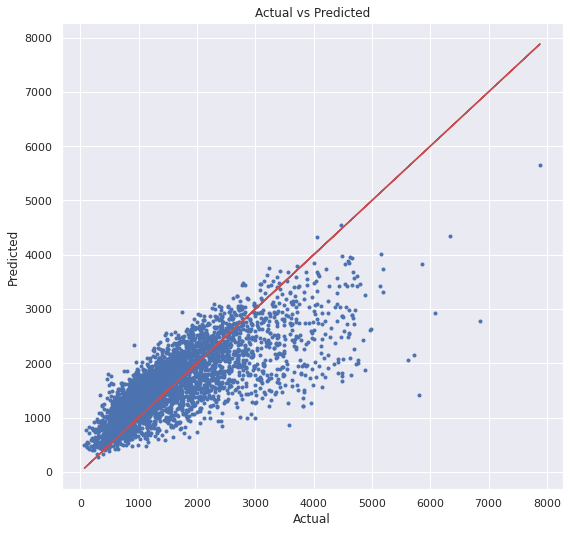

In [257]:
# Create figure and axes
f, ax = plt.subplots(figsize=(8,8))

# Plot on axes
ax.set_title('Actual vs Predicted')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.scatter(y_test,y_pred, marker='.')
ax.plot(y_test,y_test,'r')
plt.show()